### Deep Speech 2 model

In [1]:
import numpy as np
from gamma import *
from gamma.torch import *

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, bias=False):
        super().__init__()
        self.rnn = rnn_type(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            bias=bias)

    def forward(self, x):
        x, _ = self.rnn(x)
        if self.rnn.bidirectional:
            T, N, H = x.size()
            x = x.view(T, N, 2, H//2).sum(dim=2).view(T, N, H//2)
        return x

rnn = node_def(RNN)

conv_output_size = lambda input_size, kernel_size, stride, padding=0: (input_size + 2*padding - kernel_size)//stride + 1

@bind_vars
def add_bns(name, input_size, hidden_size, rnn_type, bidirectional, _in):
    LHS = {path(name, 'rnn'): (rnn(input_size, hidden_size, rnn_type, bidirectional), [_in])}
    RHS = pipeline([
        (path(name, 'rnn'), rnn(input_size, hidden_size, rnn_type, bidirectional), [_in]),
        (path(name, 'bn'), sequencewise_bn(hidden_size))
    ])
    return LHS, RHS, (path(name, 'rnn'), path(name, 'bn'))

def DS2(in_features, out_features, hidden_size, rnn_layers = 5, rnn_type = nn.GRU, bidirectional = True, recurrent_bn = True, 
        channels_1=32, channels_2=32, kernel_size_1 = (41, 11), kernel_size_2 = (21, 11), relu_clip = 20.0):
    h1 = conv_output_size(conv_output_size(in_features, kernel_size_1[0], 2), kernel_size_2[0], 2)*channels_2
    
    net =  pipeline([
        ('permute1', permute(('T', 'N', 'F'), ('N', None, 'F', 'T')), ['input']),  
        ('layer1/conv', conv(1, channels_1, kernel_size_1, stride=(2, 2), padding=(0, kernel_size_1[1]-1))),
        ('layer1/bn',   bn(channels_1)),
        ('layer1/clip', clip(0, relu_clip)),
        ('layer2/conv', conv(channels_1, channels_2, kernel_size_2, stride=(2, 1))),
        ('layer2/bn',   bn(channels_2)),
        ('layer2/clip', clip(0, relu_clip)),
        ('permute2', permute(('N', 'H', 'F', 'T'), ('T', 'N', 'H', 'F'))),
        ('flatten', flatten_last()),
        ('layer3/rnn', rnn(h1, hidden_size, rnn_type, bidirectional)),
        *((f'layer{i}/rnn', rnn(hidden_size, hidden_size, rnn_type, bidirectional)) for i in range(4,rnn_layers+3)),
        ('classifier', linear(hidden_size, out_features, bias=False))
    ])
    
    if recurrent_bn:
        net = apply_rule(net, add_bns())
    return net

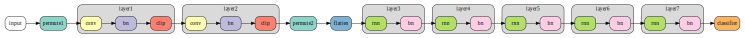

In [3]:
in_features = 161
out_features = 29
hidden_size = 800
rnn_layers=5

net = DS2(in_features, out_features, hidden_size, rnn_layers)
draw(net)

torch_net = apply_rules(net, torch_rules())
gamma_model = TorchGraph(torch_net).eval()

In [4]:
x = torch.Tensor(np.random.rand(20, 4, in_features))
output = gamma_model({'input':x})['classifier']